In [11]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from scipy.stats import entropy, iqr, kurtosis, mode, skew
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Activation, BatchNormalization, Bidirectional,
                                     Conv1D, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling1D, LSTM,
                                     MaxPool1D, MaxPooling2D, Reshape,
                                     TimeDistributed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import pickle
from pandas import read_csv, unique
from scipy.signal import argrelextrema, butter, find_peaks, lfilter, lfilter_zi


In [12]:
def signal_smoothing(df, cutoff):
    # Define the filter parameters
    nyquist_freq = 0.5 * 25  # Nyquist frequency for a 25 Hz sample rate
    normalized_cutoff = cutoff / nyquist_freq

    # Filter order selection (adjust as needed)
    order = 4

    # Create a Butterworth low-pass filter
    b, a = butter(order, float(normalized_cutoff), btype='low')
    
    # Apply the filter to the data with initial conditions
    zi = lfilter_zi(b, a)
    filtered_data, _ = lfilter(b, a, df, zi=zi*df[0])
    
    return filtered_data

In [13]:
def base_feature_extraction(df):
    time_interval = 1/25 # 1/freq
    pca = PCA(n_components=1)
    
    # calculate magnitude of vector
    df["magnitude"] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    
    # vector normalise 
    df["accel_x"] = df["accel_x"]/df['magnitude']
    df["accel_y"] = df["accel_y"]/df['magnitude']
    df["accel_z"] = df["accel_z"]/df['magnitude']
    
    max_jerk = 10
    # calculate jerk of data
    df["jerk_x"] = np.clip(np.gradient(df["accel_x"], time_interval), -max_jerk, max_jerk)
    df["jerk_y"] = np.clip(np.gradient(df["accel_y"], time_interval), -max_jerk, max_jerk)
    df["jerk_z"] = np.clip(np.gradient(df["accel_z"], time_interval), -max_jerk, max_jerk)
    df["jerk_mag"] = np.sqrt(df['jerk_x']**2 + df['jerk_y']**2 + df['jerk_z']**2)
    df["jerk_x"] = df["jerk_x"]
    df["jerk_y"] = df["jerk_y"]
    df["jerk_z"] = df["jerk_z"]
    

    # calculate most segnificant components
    df["pca_accel"] = pca.fit_transform(df[["accel_x","accel_y","accel_z"]])
    df["pca_jerk"] = pca.fit_transform(df[["jerk_x","jerk_y","jerk_z"]])
    
    # fast fourier transform to calculate frequency domain
    # time_series_cols = df[["accel_x","accel_y", "accel_z", "jerk_x","jerk_y","jerk_z","magnitude", "jerk_mag", "pca_accel", "pca_jerk"]]
    # frequency_space = np.abs(fft(time_series_cols))
    # df[["f_accel_x","f_accel_y", "f_accel_z", "f_jerk_x","f_jerk_y","f_jerk_z","f_magnitude", "f_jerk_mag", "f_pca_accel", "f_pca_jerk"]] = frequency_space
    
    
    df = df.dropna()
    return df

In [14]:
def import_file(file_dir):
    # read data from name of file
    student, sensor, activity, activity_subtype = file_dir.split("/")[-1][:-4].split("_")[:4]
    # read in database
    df = pd.read_csv(file_dir)
    # drop features we dont want
    df = df[["timestamp","accel_x","accel_y", "accel_z"]]
    df['timestamp'] = df['timestamp'].astype(np.float64)
    
    # add activity information
    df['activity'] = activity
    df['activity_subtype'] = activity_subtype
    
    #sort by timestamp
    df.sort_values(by=['timestamp'])
    # drop timestamp
    df = df.drop("timestamp", axis = 1)
    
    return df

Text(0.5, 1.0, 'Original')

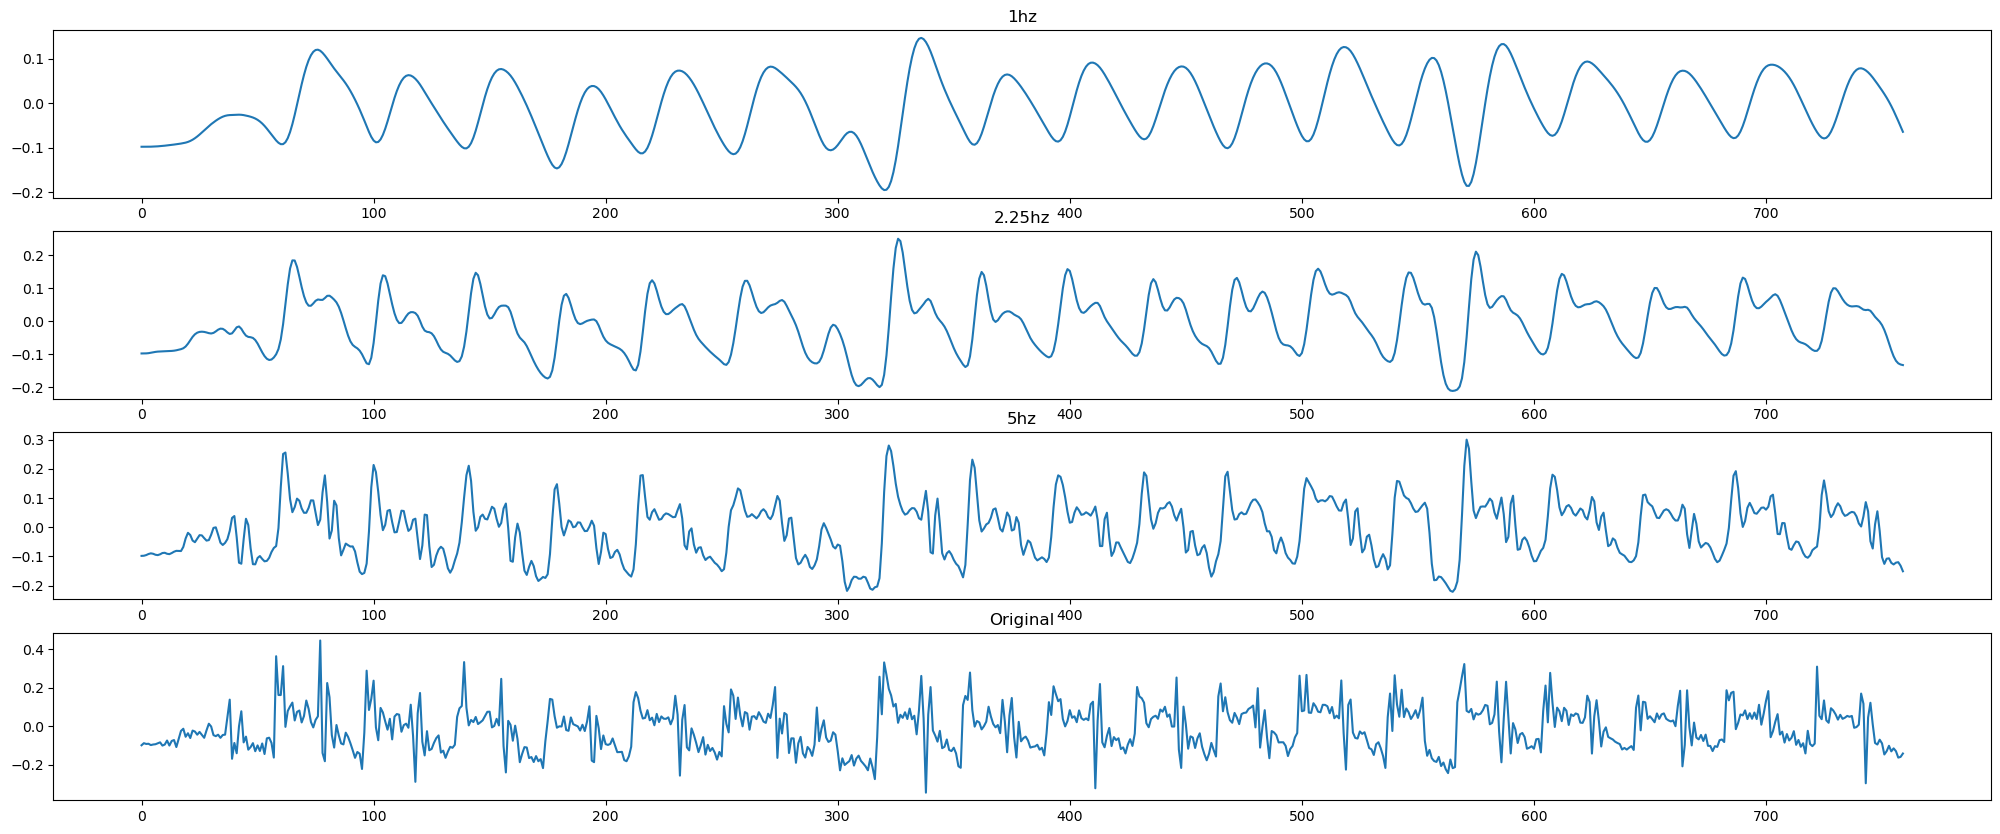

In [15]:
df = import_file("Respeck/S14/S14_respeck_ascending stairs_normal_clean.csv")
# plt.plot(df["accel_x"])
# plt.plot(signal_smoothing(df["accel_x"]),2.25)
# produce 4 subplots for 4 stages of smoothing
fig, axs = plt.subplots(4,1,figsize=(25, 10))
axs[0].plot(signal_smoothing(df["accel_x"],1))
axs[0].set_title("1hz")
axs[1].plot(signal_smoothing(df["accel_x"],2.25))
axs[1].set_title("2.25hz")
axs[2].plot(signal_smoothing(df["accel_x"],5))
axs[2].set_title("5hz")
axs[3].plot(df["accel_x"])
axs[3].set_title("Original")


In [16]:
def get_df(directory='Respeck', freq=2.25):
    # Loop through the clean-named subfolders
    all_data = pd.DataFrame()
    data_chunks = []
    
    for student in os.listdir(directory):
        if "placeholder" not in student:
            student_directory = os.path.join(directory, student)
            # itterate through students data
            for file in os.listdir(student_directory):
                file_dir = os.path.join(student_directory, file)
                if os.path.isfile(file_dir) and not "S37" in file:
                    df = import_file(file_dir)
                    if freq != -1:
                        df["accel_x"] = signal_smoothing(df["accel_x"],freq)
                        df["accel_y"] = signal_smoothing(df["accel_y"],freq)
                        df["accel_z"] = signal_smoothing(df["accel_z"],freq)
                    df = base_feature_extraction(df)
                    all_data = pd.concat([all_data, df])
                    data_chunks.append(df)
                    
    return all_data, data_chunks

In [17]:
df, data_chunks = get_df('Respeck', -1)

In [18]:
df

,accel_x,accel_y,accel_z,activity,activity_subtype,magnitude,jerk_x,jerk_y,jerk_z,jerk_mag,pca_accel,pca_jerk
0,0.696617,0.138001,0.704046,lying down right,hyperventilating,1.043338,-0.153300,-0.637547,0.262477,0.706301,0.039753,-0.143087
1,0.690485,0.112499,0.714545,lying down right,hyperventilating,1.032450,0.164498,-0.243570,-0.120756,0.317754,0.035007,-0.304153
2,0.709776,0.118516,0.694386,lying down right,hyperventilating,1.019178,0.139618,0.163593,-0.164782,0.270941,0.015366,-0.070397
3,0.701654,0.125587,0.701363,lying down right,hyperventilating,1.047330,-0.089298,0.491328,-0.006949,0.499426,0.028195,0.346477
4,0.702633,0.157822,0.693830,lying down right,hyperventilating,1.060812,0.180915,-0.486889,-0.109883,0.530910,0.041536,-0.452985
...,...,...,...,...,...,...,...,...,...,...,...,...
755,0.198705,-0.966201,0.164234,sitting,coughing,1.007503,-0.422751,-0.014238,0.400181,0.582294,0.069139,-0.493289
756,0.173063,-0.967897,0.182278,sitting,coughing,1.000188,-0.877916,-0.050995,0.510379,1.016771,0.039820,-0.717117
757,0.128471,-0.970280,0.205064,sitting,coughing,1.022390,-1.025413,-0.217357,-0.470224,1.148837,-0.004089,0.199345
758,0.091030,-0.985285,0.144660,sitting,coughing,1.000377,-0.415646,-0.094916,-0.234927,0.486787,0.024991,0.124447


In [19]:
def summarise_window(df):
    data = []
    for column in df.columns:
        data.append(column_summary(df[column]))
    return np.array(data)

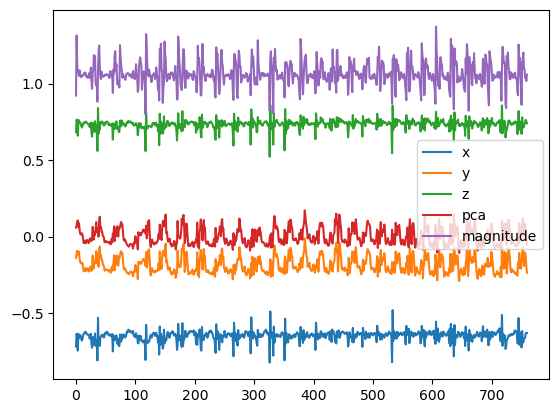

In [20]:
i=1
plt.plot(data_chunks[i]["accel_x"], label = "x")
plt.plot(data_chunks[i]["accel_y"], label ="y")
plt.plot(data_chunks[i]["accel_z"], label = "z")
plt.plot(data_chunks[i]["pca_accel"], label = "pca")
plt.plot(data_chunks[i]["magnitude"], label = "magnitude")
plt.legend()

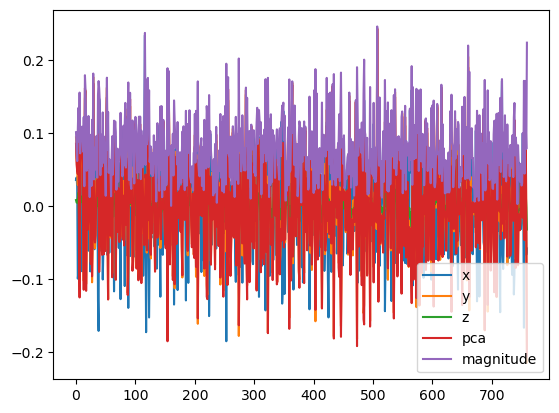

In [21]:
i=100
plt.plot(data_chunks[i]["jerk_x"], label = "x")
plt.plot(data_chunks[i]["jerk_y"], label ="y")
plt.plot(data_chunks[i]["jerk_z"], label = "z")
plt.plot(data_chunks[i]["pca_jerk"], label = "pca")
plt.plot(data_chunks[i]["jerk_mag"], label = "magnitude")
plt.legend()

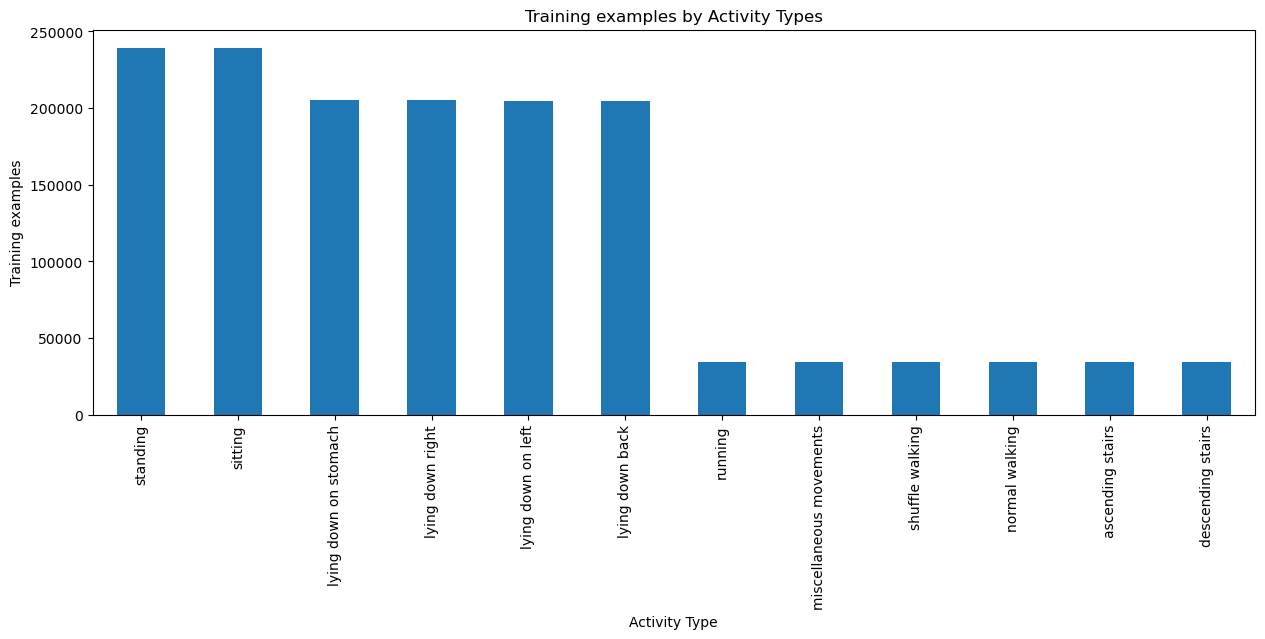

In [22]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

In [23]:
def get_X_y(data_chunks, window_size = 50, overlap = 25):
    X = []
    y = []
    for data in data_chunks:
        for i in range(0, len(data) - window_size + 1, overlap):
            # get window
            window = data[i:i + window_size].copy()
            x_data = window.drop(columns=['activity', 'activity_subtype'])
            # create X matrix
            X.append(x_data)
            # create y matrix
            y.append(window.iloc[0]['activity'])
    return np.array(X), np.array(y).reshape(-1,1)

In [24]:
X,y = get_X_y(data_chunks)

In [25]:
file = open('X_respeck_no_preprocessing_subactivity', 'wb')
pickle.dump(X, file)
file.close()
file = open('y_respeck_no_preprocessing_subactivity', 'wb')
pickle.dump(y, file)
file.close()

In [26]:
# for w in [25,50]:#,75,100,125,150]:
#     X,y = get_X_y(data_chunks, w)
#     file = open('X_respeck_' + str(w), 'wb')
#     pickle.dump(X, file)
#     file.close()
#     file = open('y_respeck_' + str(w), 'wb')
#     pickle.dump(y, file)
#     file.close()

In [27]:
# for freq in [1,2.25,5]:
#     df, data_chunks = get_df('Respeck', freq=freq)
#     X,y = get_X_y(data_chunks)
#     file = open('X_respeck_' + str(freq), 'wb')
#     pickle.dump(X, file)
#     file.close()
#     file = open('y_respeck_' + str(freq), 'wb')
#     pickle.dump(y, file)
#     file.close()

In [28]:
# file = open('X_thingy', 'wb')
# pickle.dump(X, file)
# file.close()
# file = open('y_thingy', 'wb')
# pickle.dump(y, file)
# file.close()

In [29]:
def column_summary(data):
    # Calculate Mean, Standard Deviation, Median Absolute Deviation
    mean_value = np.mean(data)
    std_dev = np.std(data)
    mad = np.median(np.abs(data - np.median(data)))

    # Calculate Minimum and Maximum Values
    minimum = np.min(data)
    maximum = np.max(data)

    # Calculate Signal Magnitude Area
    sma = np.sum(np.abs(data))

    # Calculate Energy Measure
    energy = np.sum(data ** 2) / len(data)

    # Calculate Inter-quartile Range
    interquartile_range = iqr(data)

    # Calculate Signal Entropy
    signal_entropy = entropy(data)
    
    # calculate number of peaks
    num_peaks = len(find_peaks(data))
    
    #skewness
    skewness = skew(data)
    
    #kurtosis
    kurto = kurtosis(data)

    # Auto-regression coefficients using Burg order equal to 4
    # burg_order = 4
    # coefficients = lfilter(*butter(burg_order, 0.5, output='ba'), data)
    
    return np.array([mean_value, std_dev, mad, minimum, maximum, sma, energy, num_peaks,
                    interquartile_range, signal_entropy, kurto,skewness])
    